In [29]:
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [39]:
class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    VELOCITY_BOUND = (-10, 10)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        # First 2 indexes are positions, last 2 indexes are velocity.
        self.state: npt.NDArray = np.zeros(4, dtype=np.int32)
        self.state[:2]= self.starts[np.random.choice(self.starts.shape[0]), :].copy()

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.state[2:] += self.ACTIONS[action]

        # Constrain velocity to min and max.
        self.state[2:].clip(*self.VELOCITY_BOUND, out=self.state[2:])

        # Update state.
        self.state[:2] += self.state[2:]

        # Constrain to within racetrack array.
        self.state[:2].clip(0, np.array(self.racetrack.shape) - 1, out=self.state[:2])

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state[:2])] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state[:2])] == 2:
            reward += 10
            done = True

        return self.state, reward, done

In [53]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 1000, epsilon: float = 0.1, gamma: float = 0.9) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma

        # Shape is length and width of racetrack, possible velocity values in both directions, and action index.
        num_velocities = abs(env.VELOCITY_BOUND[0] - env.VELOCITY_BOUND[1]) + 1
        shape = (*self.env.racetrack.shape, num_velocities, num_velocities, self.env.ACTION_SPACE)
        self.Q: npt.NDArray = np.zeros(shape)
        self.policy: npt.NDArray = (1 / self.env.ACTION_SPACE) * np.ones(shape)
        self.count: npt.NDArray = np.zeros(shape)
        self.rewards: list = []

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode(training=False)
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - MC Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self, training: bool = True) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = self.env.state.copy()
            probabilities = self.policy[tuple(state)].copy()
            probabilities = probabilities / np.sum(probabilities)
            if training:
                action = np.random.choice(self.env.ACTION_SPACE, p=probabilities)
            else:
                action = np.argmax(probabilities)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
        
        return episode

    def mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            self.rewards.append(sum([step[2] for step in episode]))
            print(i, self.rewards[-1])

            # Get discounted total returns for each time step.
            returns = []
            total = 0
            for _, _, reward in reversed(episode):
                returns.append(reward + self.gamma * total)
                total += reward
            returns.reverse()

            for t, (state, action, reward) in enumerate(episode):
                state_idx = tuple(state)
                action_idx = (action,)

                self.count[state_idx + action_idx] += 1
                self.Q[state_idx + action_idx] += (returns[t] - self.Q[state_idx + action_idx]) / self.count[state_idx + action_idx]
                optimal_action = np.argmax(self.Q[state_idx])
                
                for a in self.env.get_actions():
                    if (a == optimal_action).all():
                        self.policy[state_idx, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state_idx, a] = self.epsilon / self.env.ACTION_SPACE

0 -6742
1 -1451
2 -543
3 -3405
4 -4122
5 -2824
6 -3375
7 -4576
8 -5123
9 -3534
10 -3012
11 -1593
12 -2939
13 -4736
14 -6820
15 -2260
16 -1457
17 -1243
18 -6996
19 -31
20 -2513
21 -1470
22 -9146
23 -984
24 -9365
25 -3857
26 -1411
27 -1031
28 -2082
29 -4282
30 -9535
31 -1303
32 -15233
33 -8837
34 -1051
35 -2303
36 -9760
37 -1592
38 -361
39 -1554
40 -1538
41 -1000
42 -5861
43 -11281
44 -1676
45 -8234
46 -7590
47 -825
48 -2532
49 -4777
50 -1061
51 -12316
52 -1416
53 -2851
54 -4404
55 -1971
56 -6046
57 -285
58 -2674
59 2
60 -857
61 -405
62 -943
63 -2438
64 -12120
65 -2403
66 -5881
67 -4731
68 -328
69 -7473
70 -2294
71 -250
72 -6369
73 -376
74 -2425
75 -5064
76 -13774
77 -12342
78 -790
79 -3632
80 -1297
81 -2572
82 -12237
83 -5111
84 -4103
85 -1148
86 -340
87 -7400
88 -6055
89 -4937
90 -306
91 -3102
92 -1784
93 -6160
94 -11806
95 -171
96 -3420
97 -1309
98 -2925
99 -2748
100 -3930
101 -2535
102 -12877
103 -7416
104 -1730
105 -7612
106 -904
107 -2250
108 -5636
109 -2992
110 -1591
111 -12940
11

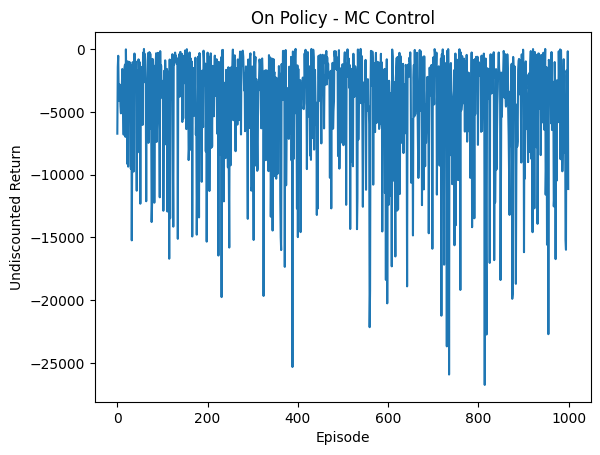

In [54]:
env = Environment("./racetrack2.csv")
agent = Agent(env)
agent.mc()
agent.print_action()
agent.plot_rewards()